## Neeya Devanagondi, Manas Gandhi, Rahul Kasibhatla (Coding Assignment 5)

## Problem 1

In [4]:
import pandas as pd
mall = pd.read_csv("Mall_Customers.csv")
mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
from sklearn.preprocessing import StandardScaler

df = mall.copy()

# 1) Create age groups so we can one-hot encode "Age" as a categorical-like variable
age_bins = [0, 25, 40, 60, 100]
age_labels = ["Young", "Adult", "MiddleAge", "Senior"]
df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=True)

# 2) One-hot encode AgeGroup and Gender
df = pd.get_dummies(df, columns=["AgeGroup", "Genre"], drop_first=True)

# 3) Drop CustomerID (not useful for clustering)
if "CustomerID" in df.columns:
    df = df.drop(columns=["CustomerID"])

# 4) Keep a copy of original numeric features for interpretation later
feature_cols = df.columns

# 5) Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
def plot_income_vs_spending(original_df, cluster_labels, title):
    """
    Scatter plot of Annual Income vs Spending Score color-coded by cluster.
    Assumes original_df contains 'Annual Income (k$)' and 'Spending Score (1-100)'.
    """
    plt.figure()
    scatter = plt.scatter(
        original_df["Annual Income (k$)"],
        original_df["Spending Score (1-100)"],
        c=cluster_labels,
        cmap="viridis"
    )
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
    plt.title(title)
    plt.colorbar(scatter, label="Cluster")
    plt.show()


def cluster_summary(original_df, cluster_labels):
    """
    Compute summary statistics per cluster for interpretation.
    Returns a DataFrame of means grouped by cluster.
    """
    tmp = original_df.copy()
    tmp["Cluster"] = cluster_labels
    summary = tmp.groupby("Cluster").agg(
        {
            "Age": ["mean", "min", "max"],
            "Annual Income (k$)": ["mean", "min", "max"],
            "Spending Score (1-100)": ["mean", "min", "max"]
        }
    )
    return summary

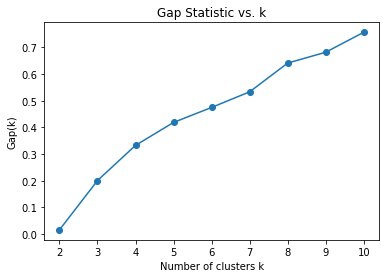

k selected by Gap Statistic: 10


In [15]:
# Cell 6: Compute Gap Statistic over a range of k

from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


def compute_kmeans_inertia(X, n_clusters, random_state=598):
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    km.fit(X)
    return km.inertia_

def compute_gap_statistic(X, ks, B=10, random_state=598):
    """
    Compute Gap Statistic:
    - ks: list or array of k values to evaluate
    - B: number of reference datasets
    Returns:
    - gaps: list of gap values per k
    - s_k: standard deviation term per k
    """
    np.random.seed(random_state)
    X = np.array(X)
    n, d = X.shape

    # Bounds for generating reference data
    mins = X.min(axis=0)
    maxs = X.max(axis=0)

    gaps = []
    s_k = []

    for k in ks:
        # Wk: inertia for original data
        Wk = compute_kmeans_inertia(X, k, random_state=random_state)

        # Wk* for B reference datasets
        Wk_bs = []
        for b in range(B):
            X_ref = np.random.uniform(low=mins, high=maxs, size=(n, d))
            Wk_bs.append(compute_kmeans_inertia(X_ref, k, random_state=random_state + b + 1))

        log_Wk_bs = np.log(Wk_bs)
        gap_k = np.mean(log_Wk_bs) - np.log(Wk)
        sk = np.sqrt(1 + 1.0 / B) * np.std(log_Wk_bs)

        gaps.append(gap_k)
        s_k.append(sk)

    return np.array(gaps), np.array(s_k)

# Choose range of k to explore
ks = np.arange(2, 11)

gaps, s_k = compute_gap_statistic(X_scaled, ks, B=10)

# Plot Gap Statistic
plt.figure()
plt.plot(ks, gaps, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Gap(k)")
plt.title("Gap Statistic vs. k")
plt.show()

# A simple rule: choose k that maximizes Gap(k)
k_gap = None
for i in range(len(ks)-1):
    if gaps[i] >= gaps[i+1] - s_k[i+1]:
        k_gap = ks[i]
        break

if k_gap is None:
    k_gap = ks[-1]
print("k selected by Gap Statistic:", k_gap)
